## DCGAN Architecture

![Generator architecture](./assets/dcgan.png)

Figure: Architectural drawing of the DCGAN from [Radford et al (2016)](https://arxiv.org/pdf/1511.06434v1.pdf).

In [1]:
import numpy as np
import torch
from torch import nn
from tqdm.auto import tqdm
import torchvision
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
import torchvision.utils as vutils
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using", device)

Using cuda


# 1. Building the Generator

In [2]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_chan: the number of channels of the output image, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN, 
        corresponding to a transposed convolution, a batchnorm (except for in the last layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU()
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh()
            )

    def unsqueeze_noise(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns a copy of that noise with width and height = 1 and channels = z_dim.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        return noise.view(len(noise), self.z_dim, 1, 1)

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        x = self.unsqueeze_noise(noise)
        return self.gen(x)

    
def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    '''
    return torch.randn(n_samples, z_dim, device=device)

# 2. Building the Discriminator

In [3]:
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
        im_chan: the number of channels of the output image, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
    hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_chan=1, hidden_dim=16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, 1, final_layer=True),
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a discriminator block of DCGAN, 
        corresponding to a convolution, a batchnorm (except for in the last layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2)
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
            )

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_dim)
        '''
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

# 3. Initialize Parameters

In [4]:
criterion = nn.BCEWithLogitsLoss()  # Loss
z_dim = 64  # Noise vector dimension
display_step = 500  # Show intermediary results every n steps
batch_size = 128
lr = 0.0002

beta_1 = 0.5  # Betas for Adam optimizer as proposed in the Paper.
beta_2 = 0.999
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])
dataloader = DataLoader(
    MNIST('./data/', download=False, transform=transform),
    batch_size=batch_size,
    shuffle=True)

In [5]:
# Initialize Models
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

# Initialize the weights to the normal distribution
# with mean 0 and standard deviation 0.02 as proposed by DCGAN Paper
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

# 4. Training

In [6]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

Epoch 1 Step 500: Generator loss: 0.9292837074995044, discriminator loss: 0.5128773638308048


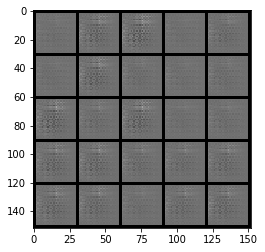

Epoch 2 Step 1000: Generator loss: 2.1346472947895525, discriminator loss: 0.19214848082512634


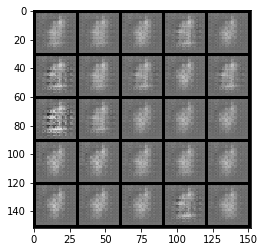

Epoch 3 Step 1500: Generator loss: 1.745784239768981, discriminator loss: 0.3734027990102768


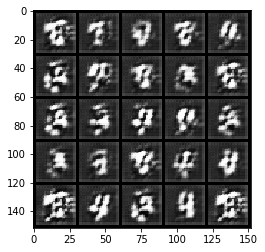

Epoch 4 Step 2000: Generator loss: 1.1556021744906906, discriminator loss: 0.5083485623002055


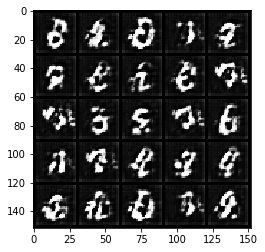

Epoch 5 Step 2500: Generator loss: 0.978714042723179, discriminator loss: 0.563296568214893


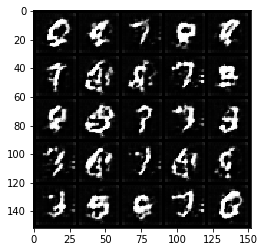

Epoch 6 Step 3000: Generator loss: 0.9050547293424602, discriminator loss: 0.5930198981761933


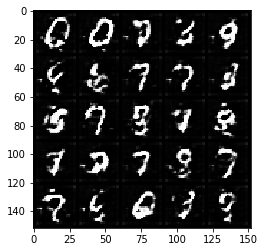

Epoch 7 Step 3500: Generator loss: 0.8582624992132188, discriminator loss: 0.6136772297620774


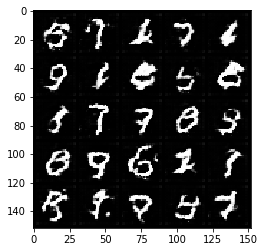

Epoch 8 Step 4000: Generator loss: 0.8307659589648243, discriminator loss: 0.6267244559526445


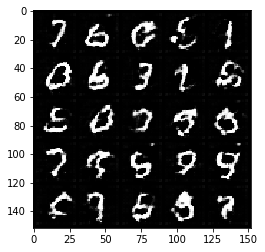

Epoch 9 Step 4500: Generator loss: 0.8237807614207266, discriminator loss: 0.640341027736664


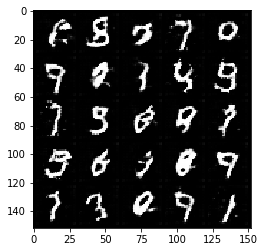

Epoch 10 Step 5000: Generator loss: 0.8046228226423261, discriminator loss: 0.6483348966836934


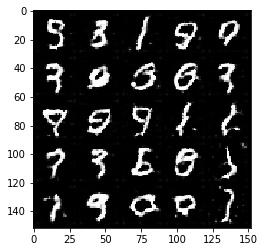

Epoch 11 Step 5500: Generator loss: 0.7980864460468287, discriminator loss: 0.6571166993379594


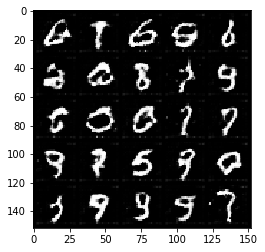

Epoch 12 Step 6000: Generator loss: 0.790168697059155, discriminator loss: 0.6586213195323946


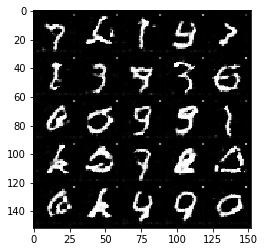

Epoch 13 Step 6500: Generator loss: 0.7854352247715, discriminator loss: 0.6602900960445407


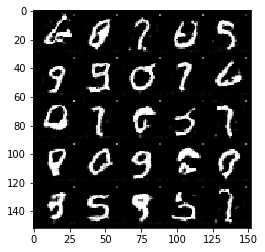

Epoch 14 Step 7000: Generator loss: 0.7803913226127628, discriminator loss: 0.6633557622432706


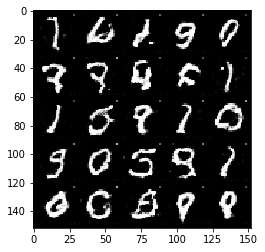

Epoch 15 Step 7500: Generator loss: 0.7753767015337936, discriminator loss: 0.6664125927686702


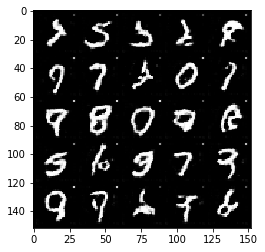

Epoch 17 Step 8000: Generator loss: 0.7707118590474122, discriminator loss: 0.666998810768128


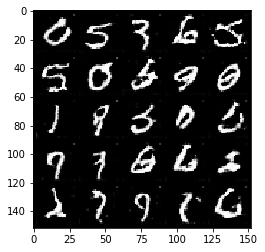

Epoch 18 Step 8500: Generator loss: 0.768598741710185, discriminator loss: 0.6682328636646272


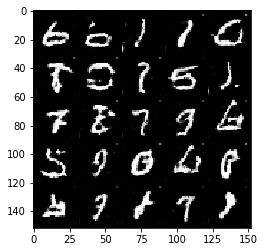

Epoch 19 Step 9000: Generator loss: 0.7647196828424929, discriminator loss: 0.6727254542112346


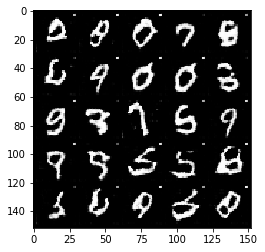

Epoch 20 Step 9500: Generator loss: 0.7536313031017778, discriminator loss: 0.6778734813928597


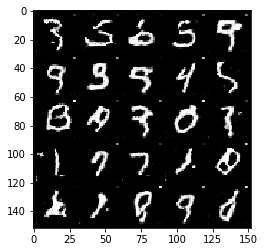

Epoch 21 Step 10000: Generator loss: 0.7493764933943747, discriminator loss: 0.680292599916458


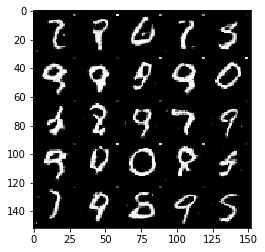

Epoch 22 Step 10500: Generator loss: 0.7478209498524668, discriminator loss: 0.6836617493629459


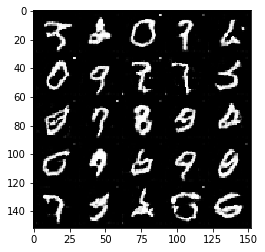

Epoch 23 Step 11000: Generator loss: 0.7400000056922433, discriminator loss: 0.6878126651048659


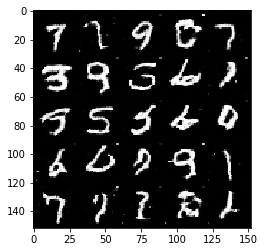

Epoch 24 Step 11500: Generator loss: 0.7361074898838995, discriminator loss: 0.6864336740970612


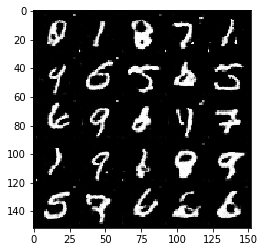

Epoch 25 Step 12000: Generator loss: 0.737439711511135, discriminator loss: 0.6875900181531903


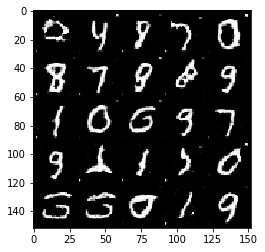

Epoch 26 Step 12500: Generator loss: 0.7357433266639715, discriminator loss: 0.6875470681190501


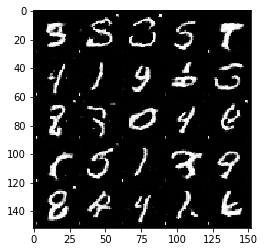

Epoch 27 Step 13000: Generator loss: 0.7324522644877428, discriminator loss: 0.6888902381658557


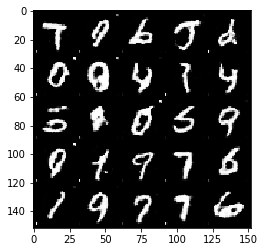

Epoch 28 Step 13500: Generator loss: 0.7293548277616504, discriminator loss: 0.6894202454090114


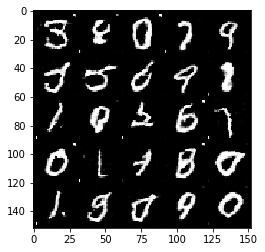

Epoch 29 Step 14000: Generator loss: 0.7268637665808195, discriminator loss: 0.6923018423318872


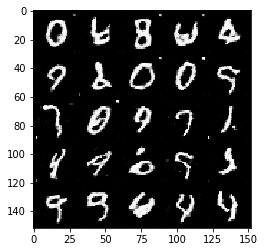

Epoch 30 Step 14500: Generator loss: 0.7271829720437517, discriminator loss: 0.6937861622571942


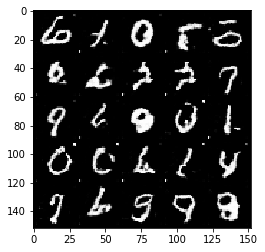

Epoch 31 Step 15000: Generator loss: 0.7249248664975165, discriminator loss: 0.6906202113628392


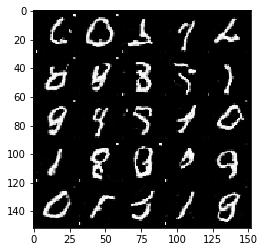

Epoch 33 Step 15500: Generator loss: 0.721207998752594, discriminator loss: 0.6922989832162859


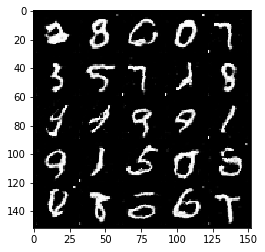

Epoch 34 Step 16000: Generator loss: 0.7233851940631869, discriminator loss: 0.6904099067449575


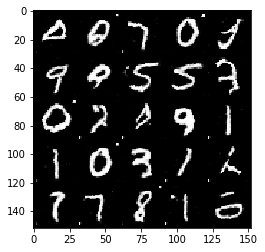

Epoch 35 Step 16500: Generator loss: 0.7237198286056523, discriminator loss: 0.691843695998192


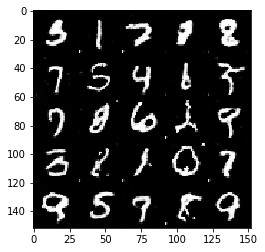

Epoch 36 Step 17000: Generator loss: 0.7198368291258808, discriminator loss: 0.6929174430370328


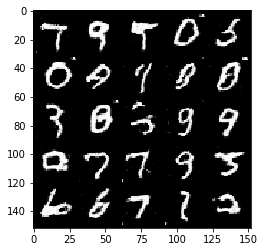

Epoch 37 Step 17500: Generator loss: 0.7184776564240454, discriminator loss: 0.6945277898311616


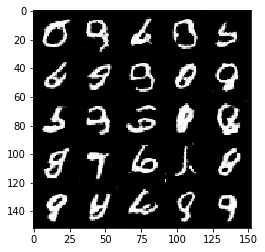

Epoch 38 Step 18000: Generator loss: 0.7183322201967239, discriminator loss: 0.6933540230989456


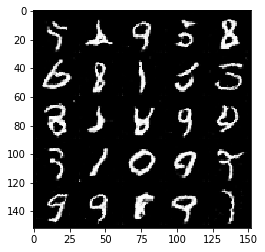

Epoch 39 Step 18500: Generator loss: 0.7154221737384788, discriminator loss: 0.693974142432213


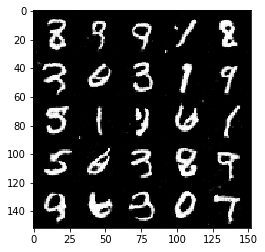

Epoch 40 Step 19000: Generator loss: 0.7133249400258058, discriminator loss: 0.6936144373416897


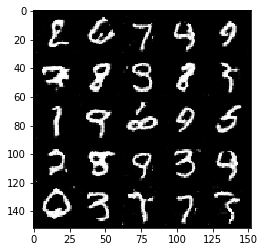

Epoch 41 Step 19500: Generator loss: 0.7113263387680049, discriminator loss: 0.6966983968019484


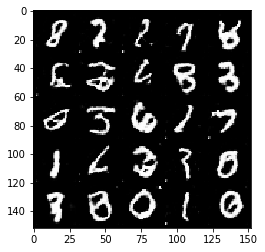

Epoch 42 Step 20000: Generator loss: 0.7105149267315872, discriminator loss: 0.6961457246541973


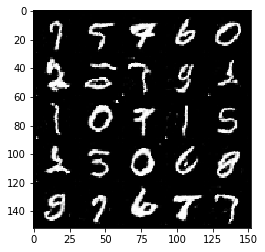

Epoch 43 Step 20500: Generator loss: 0.7097937676310536, discriminator loss: 0.6955876891613011


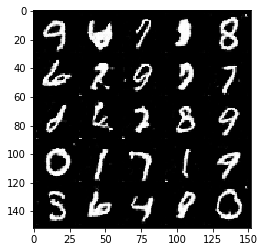

Epoch 44 Step 21000: Generator loss: 0.7086598223447798, discriminator loss: 0.6963706055879595


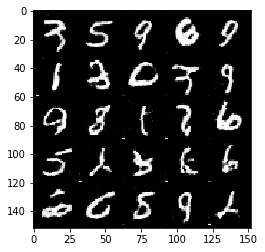

Epoch 45 Step 21500: Generator loss: 0.7086307970881459, discriminator loss: 0.6961116199493409


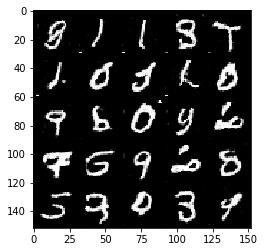

Epoch 46 Step 22000: Generator loss: 0.709035045444965, discriminator loss: 0.6963321468830104


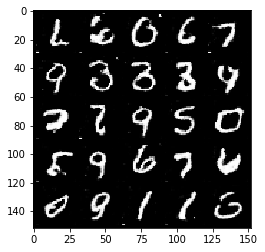

Epoch 47 Step 22500: Generator loss: 0.7081469666957855, discriminator loss: 0.6964486534595494


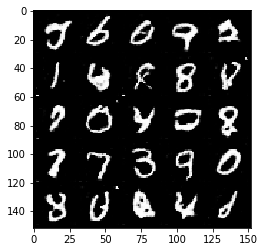

Epoch 49 Step 23000: Generator loss: 0.706290502250194, discriminator loss: 0.6970822728872297


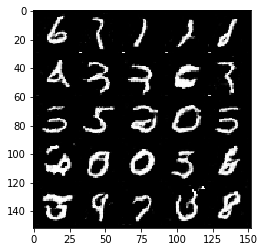

In [7]:
n_epochs = 50
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0

gen_losses = []
disc_losses = []

for epoch in range(n_epochs):
    # Dataloader returns the batches
    for real, _ in dataloader:
        cur_batch_size = len(real)
        real = real.to(device)

        ## Update discriminator ##
        disc_opt.zero_grad()
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        fake = gen(fake_noise)
        disc_fake_pred = disc(fake.detach())
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_pred = disc(real)
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step
        # Update gradients
        disc_loss.backward(retain_graph=True)
        # Update optimizer
        disc_opt.step()

        ## Update generator ##
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        disc_fake_pred = disc(fake_2)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step
        
        # Keep track of all losses for graph later
        gen_losses.append(gen_loss.item())
        disc_losses.append(disc_loss.item())

        ## Visualization code ##
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Epoch {epoch} Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            show_tensor_images(fake)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1



# 5. Plot the Loss

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl

mpl.rcParams['lines.linewidth'] = 5
mpl.rcParams['lines.markersize'] = 10
mpl.rcParams['font.size'] = 15
mpl.rcParams['figure.figsize'] = (15, 8)
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.autolayout'] = True

In [28]:
df_disc = pd.DataFrame({"Model":["Discriminator" for _ in disc_losses], "Loss":disc_losses, "Step":list(range(len(disc_losses)))})
df_gen = pd.DataFrame({"Model":["Generator" for _ in disc_losses], "Loss":gen_losses, "Step":list(range(len(gen_losses)))})

df_disc["Loss"] = df_disc["Loss"].rolling(20).mean()
df_gen["Loss"] = df_gen["Loss"].rolling(20).mean()

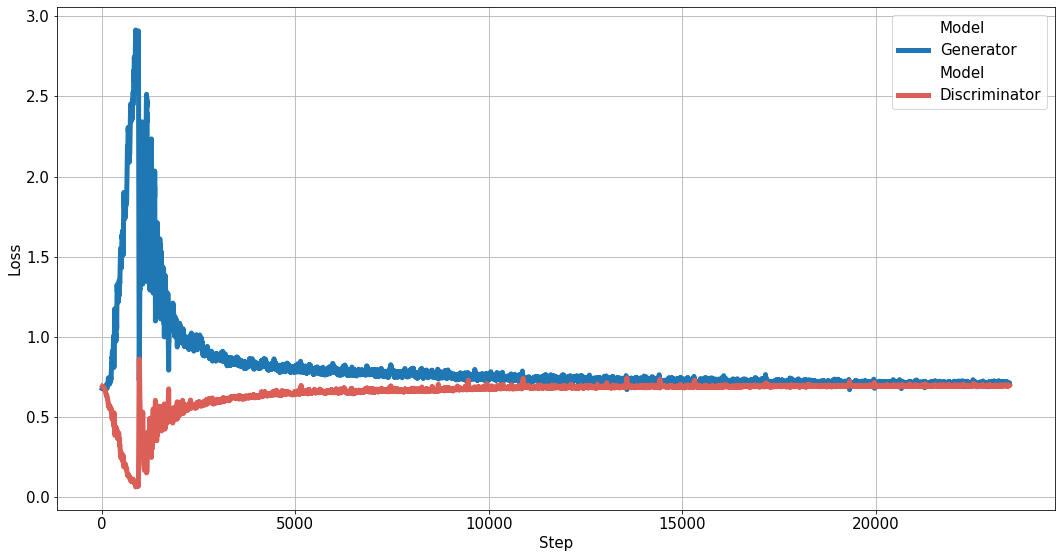

In [29]:
palette = sns.color_palette("hls", 1)
sns.lineplot(data=df_gen, x="Step", y="Loss", hue="Model")
sns.lineplot(data=df_disc, x="Step", y="Loss", hue="Model",  palette=palette)
plt.grid()

In [30]:
print("Done!")

Done!
